<div align="right">Alejandro Cartas 21 Octuber 2015</div>

# Getting started with Caffe on Docker environment

## What is a Deep Learning programming framework?

Is a combination of specialized hardware and software to create and train Deep Learning networks. The framework stack shown below corresponds to the GPU stack and some components are optional. In this guide we will use a CPU stack.

![Deep Learning Framework Stack](software-hardware-deepLearningStack.png "Deep Learning Framework Stack")
*Adapted figure from [Nvidia courseware](https://developer.nvidia.com/deep-learning-courses).*

## Why use Caffe?

Every Deep Learning framework has its advantages and its drawbacks. I'll use Caffe mainly because it seems to be more out-of-the-box than Theano. But many researchers prefer Theano because of its detailed programming level. See a Reddit discussion on a *Best framework for Deep Neural Nets?* at [https://www.reddit.com/comments/2c9x0s](https://www.reddit.com/comments/2c9x0s).

![GPU-Accelarated Deep Learning Frameworks](nvidiaFramewokComparisonTable.png "GPU-Accelarated Deep Learning Frameworks")
*Deep learning frameworks comparison table from [Nvidia courseware](https://developer.nvidia.com/deep-learning-courses).*

## Why use Caffe on a Docker container?

Perhaps is the easiest and fastest way to get started with Caffe without breaking your system and your nerves.

## Setup

**1. Install VirtualBox and Docker.** Docker is a container that holds an entire OS and runs over a virtual machine, in this case it is VirtualBox. Some Docker installation packages already contain a VirtualBox inside, but you can download VirtualBox for free at [https://www.virtualbox.org/wiki/Downloads](https://www.virtualbox.org/wiki/Downloads). Additionally, a detailed and easy guide for installing Docker on your system can be found here [https://docs.docker.com/installation/](https://docs.docker.com/installation/).

**2. Download and start the Caffe image.** Four different Caffe images for Docker are linked in the official site at [https://github.com/BVLC/caffe/wiki/Installation](https://github.com/BVLC/caffe/wiki/Installation). We will use a stable build of Caffe NoGPU. After running the Docker Terminal we type in the terminal:

```bash
# Pulling the stable build Caffe (NoGPU) image for Docker
docker pull tleyden5iwx/caffe-cpu-master
```
	
Now, lets start our newly downloaded image:

```bash
docker run -i -t tleyden5iwx/caffe-cpu-master:latest /bin/bash
```

We will be logged in our Caffe image with a similar prompt like this one **root@4dabab76fab3:~/caffe#**. The hostname displayed in the prompt corresponds to the *Container ID*, in this case the *4dabab76fab3* is our Container ID. It is important to keep the *Container ID* to commit any changes to the image.

**3. Installing the required stuff.**  These steps will install the required packages to have a Jupyter notebook working. (Note that the current user is root).
```bash
# Updating our system
apt-get update &&  apt-get upgrade
		
# Installing numerical libraries
sudo apt-get install liblapack-dev liblapack-doc-man liblapack-doc liblapack-pic liblapack3 liblapack-test liblapack3gf liblapacke liblapacke-dev

# Installing Python's pip and Jupyter
apt-get install python-pip python-numpy python-scipy python-matplotlib python-pandas python-sympy python-nose libatlas3gf-base python-sklearn python-yaml nano
pip install jupyter	
```
                   		 
## Getting started with LeNet on MNIST dataset

<span style="color:red;font-weight:bold">IMPORTANT NOTE: A walkthrough guide of the LeNet network can be found on</span> **[https://github.com/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb](https://github.com/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb)**. <span style="color:red;font-weight:bold">So if you pretend to follow the other guide, you can simply do the second and third steps of this section and skip the rest.</span>
	 
**1. Training the LeNet network.**

```bash
# Going to the Caffe directory
cd /opt/caffe
 
# Downloading the MNIST dataset
./data/mnist/get_mnist.sh 
 
# Converts the data into lmdb/leveldb format (Calls a C++ binary that does the dirty job)
./examples/mnist/create_mnist.sh
```

*An error reporting that **libdc1394 error: Failed to initialize libdc1394** can appeared. You don't have to worry about this error since it seems to be related with the Docker image itself. A *"solution"* can be found [here](http://stackoverflow.com/questions/12689304/ctypes-error-libdc1394-error-failed-to-initialize-libdc1394).*

Since we are using only the CPU, we must do something before training the model. We have to replace the line *solver_mode: GPU* for *solver_mode: CPU* in the ** lenet_solver.prototxt ** file. We can do this as follows

```bash
sed -i 's/solver_mode: GPU/solver_mode: CPU/' examples/mnist/lenet_solver.prototxt
```

Now lets train the model by doing

```bash
./build/tools/caffe train --solver=examples/mnist/lenet_solver.prototxt
```

This will take a few minutes and will output logging messages. When it is done training the model, it will create the files **lenet_iter_10000.caffemodel** and **lenet_iter_10000.solverstate** on the *examples/mnist/* directory.

**2. Saving the container image.** Now we should logout the current running image and save it. We can logout the image by typing *exit* and hitting enter or by pressing **Ctrl+D**. We can save the image using the Container ID we got in step 3.

```bash
docker commit -m "Setup completed" 4dabab76fab3 tleyden5iwx/caffe-cpu-master:v1
```

**3. Running Jupyter notebook.**  We can simply call a Jupyter notebook using the next command:

```bash
docker run -i -p 8888:8888 -t tleyden5iwx/caffe-cpu-master:v1 /bin/bash -c 'cd /opt/caffe && jupyter notebook --port=8888 --ip="*" --no-browser'
```
<span style="color:red;font-weight:bold">Note that this opens a Jupyter notebook session to everybody and could be a security concern.</span>

Now we can open the notebook on any browser using the assigned ip address to Docker. We can find its ip by typing on the terminal:

```bash
docker-machine ip default
```

While writing this guide my Docker ip was 192.168.99.100, so Jupyter can be accessed on [http://192.168.99.100:8888](http://192.168.99.100:8888).

**4. Trying some MNIST test examples.** After creating a Jupyter notebook on our Docker machine, we have to do the usual setup stuff:

In [1]:
import caffe

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib as mpl
import numpy as np
import os
import struct

%matplotlib inline

Since the digits of the MNIST were stored in a special format, we need to load them:

In [2]:
# Function adapted from https://gist.github.com/akesling/5358964.
def load_mnist_test_data(path = "."):

    fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
    fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], np.reshape(img[idx], (28,28,1)))

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)
        
test_set=load_mnist_test_data("/opt/caffe/data/mnist/")

Now we can visualize one by one as follows (<span style="color:red;font-style:italic;">Please note that the grayscale is inverse plotted</span>):

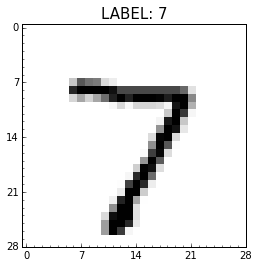

In [3]:
def plot_mnist_digit(image, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
        
    imgplot = ax.imshow(image[:,:,0], cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
                                  
    major_ticks = np.arange(0, 29, 7)                                              
    minor_ticks = np.arange(0, 28, 1)                                               

    ax.set_xticks(major_ticks)                                                       
    ax.set_xticks(minor_ticks, minor=True)                                           
    ax.set_yticks(major_ticks)                                                       
    ax.set_yticks(minor_ticks, minor=True)                                           

#     ax.grid(which='both',color='gray', linestyle='-',linewidth=0.5)
    
    if not title == None:
        plt.title(title, fontsize=15) 
    plt.show()
        
digit = next(test_set)
label = digit[0]; image = digit[1]
plot_mnist_digit(image, "LABEL: " + str(label))

Now we can do some predictions using our trained LeNet model

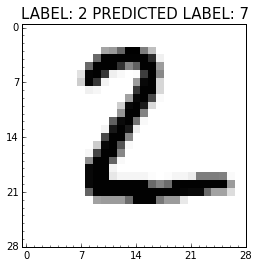

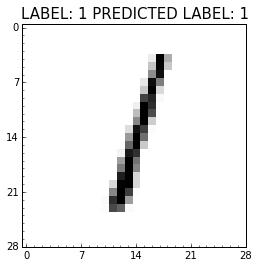

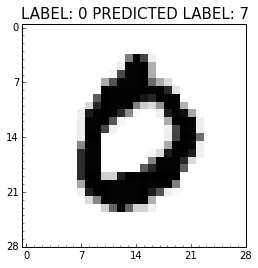

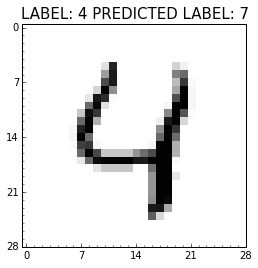

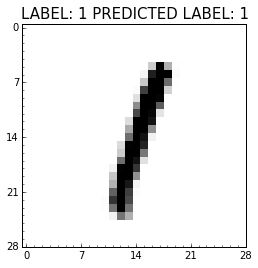

In [4]:
# Creating our trained classifier
classifier = caffe.Classifier('/opt/caffe/examples/mnist/lenet.prototxt', 
                              '/opt/caffe/examples/mnist/lenet_iter_10000.caffemodel')

for i in xrange(5):
    digit = next(test_set)
    label = digit[0]; image = digit[1]
    
    prediction = classifier.predict([image], oversample=False)
    
    predicted_label=np.argmax(prediction)    
    plot_mnist_digit(image, "LABEL: " + str(label) + " PREDICTED LABEL: "+ str(predicted_label))

## Useful resources

* Walkthrough examples can be found on [https://github.com/BVLC/caffe/tree/master/examples](https://github.com/BVLC/caffe/tree/master/examples).
* I used some steps from this guide [http://radar.oreilly.com/2014/07/how-to-build-and-run-your-first-deep-learning-network.html](http://radar.oreilly.com/2014/07/how-to-build-and-run-your-first-deep-learning-network.html).
* Docker cheatsheet [https://github.com/wsargent/docker-cheat-sheet](https://github.com/wsargent/docker-cheat-sheet).
* The Docker Book by James Turnbull.